In [1]:
# 기본 패키지
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import json

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
## 이미지에서 한글이 나오게 하는 설정
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

## 야후 파이낸스 패키지 ## pip install yfinance
import yfinance as yf

## 연준 패키지 ## pip install fredapi
from fredapi import Fred
## fred = Fred(api_key='Your API Key')

fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

In [2]:
## 사전 정의한 함수 모음
import graphModule as gm
import myfuncs as mf
from quant_functions import anal_funcs
import vidya as vd
import baseloader
import portfolio_obtimizer

In [3]:
## color 설정
with open('colors.json') as f:
    mycolors = json.load(f)

## Dataload

In [4]:
df_imp = pd.read_csv('trend_data.csv', index_col=0)
df_imp.index = pd.to_datetime(df_imp.index)
dataset = df_imp.copy()[:]
dataset = dataset[['TQQQ', 'SGOV']]

In [105]:
# 전략 실행
short_period = 20
long_period = 200
vidya = True
long_word = 'VIDYA' if vidya else 'SMA'
allocation = vd.VidyaAssetAllocation(data=dataset, cash_asset='SGOV', short_period=short_period, long_period=long_period,  alpha_factor=0.2, vidya=vidya)
portfolio, short_df, long_df = allocation.backtest()

In [106]:
result = dataset.copy()
result['Strategy'] = portfolio['Value']
## 판단 이후 시점부터
result = result[long_period:]
result = result/result.iloc[0] * 100

In [107]:
signal_df = dataset[['TQQQ']].copy()
signal_df[f'SMA_{short_period}'] = short_df['TQQQ']
signal_df[f'{long_word}_{long_period}'] = long_df['TQQQ']

In [108]:
## shock case
with open('shockCase.json', encoding='utf-8') as f:
    shock_cases = json.load(f)
## color 설정
with open('colors.json') as f:
    mycolors = json.load(f)

highlight_periods = [(shock_cases['1차오일쇼크_t0'], shock_cases['1차오일쇼크_t1']),
                     (shock_cases['2차오일쇼크_t0'], shock_cases['2차오일쇼크_t1']),
                     (shock_cases['물가충격_t0'], shock_cases['물가충격_t1']),
                     (shock_cases['걸프전_t0'], shock_cases['걸프전_t1']),
                     (shock_cases['닷컴버블_t0'], shock_cases['닷컴버블_t1']),
                     (shock_cases['금융위기_t0'], shock_cases['금융위기_t1']),
                     (shock_cases['코로나_t0'], shock_cases['코로나_t1'])]

# color 설정
colors = [mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub'], mycolors['color_norm2'], mycolors['color_cont2']]

In [110]:
def trend_cross_plot(df, highlight_periods=highlight_periods, colors=[mycolors['color_norm3'], mycolors['color_norm2'], mycolors['color_cont']], title=True, yscale='log'):
    """
    Plots a cumulative return graph for short and long trends with directional arrow markers at crossover points.

    Parameters:
        df (DataFrame): A DataFrame containing date-indexed asset data.
        highlight_periods (list of tuples): List of (start_date, end_date) tuples to highlight on the graph.
        colors (list): List of colors for the lines.
    """
    assets = df.columns
    data = df[assets].copy()
    _df = data.reset_index()
    _df = _df.melt(id_vars='Date', value_vars=_df.columns, var_name='Ticker', value_name='Value')

    # 색상 수 조정
    if len(colors) > len(assets):
        colors = colors[:len(assets)]

    fig, ax = plt.subplots(figsize=(12, 8))
    sns.lineplot(data=_df, x='Date', y='Value', hue='Ticker', palette=colors, linestyle='-', linewidth=2, ax=ax, zorder=1)

    # 교차점 계산
    cross = np.sign(df[assets[1]] - df[assets[2]]).diff().fillna(0)

    # 상향 돌파 (short > long)
    upward_cross = cross[cross > 0].index
    # 하향 돌파 (short < long)
    downward_cross = cross[cross < 0].index

    # 교차점 표시 (상향 돌파)
    ax.scatter(upward_cross, df.loc[upward_cross, assets[2]], color='green', marker='^', s=100, label='Golden Cross (▲)', zorder=5)
    # 교차점 표시 (하향 돌파)
    ax.scatter(downward_cross, df.loc[downward_cross, assets[2]], color='red', marker='v', s=100, label='Dead Cross (▼)', zorder=5)

    if title:
        ax.set_title(f'Trends with Cross Points ({data.index[0].year}~{data.index[-1].year})', fontsize=22, fontweight='bold')

    ax.set_ylabel(f"", fontsize=14, labelpad=-50, loc="top", rotation=0)
    ax.set_xlabel("Date", fontsize=14)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)

    if yscale == 'log':
        ax.set_yscale('log')

    ax.grid(color="gray", linestyle="--", linewidth=0.7, alpha=0.7)

    x_min, x_max = data.index.min(), data.index.max()
    if highlight_periods:
        for start, end in highlight_periods:
            start_date = pd.to_datetime(start)
            end_date = pd.to_datetime(end)
            if start_date > x_max or end_date < x_min:
                continue
            ax.axvspan(start_date, end_date, facecolor="gray", alpha=0.30)

    plt.tight_layout()
    plt.legend()
    plt.show()


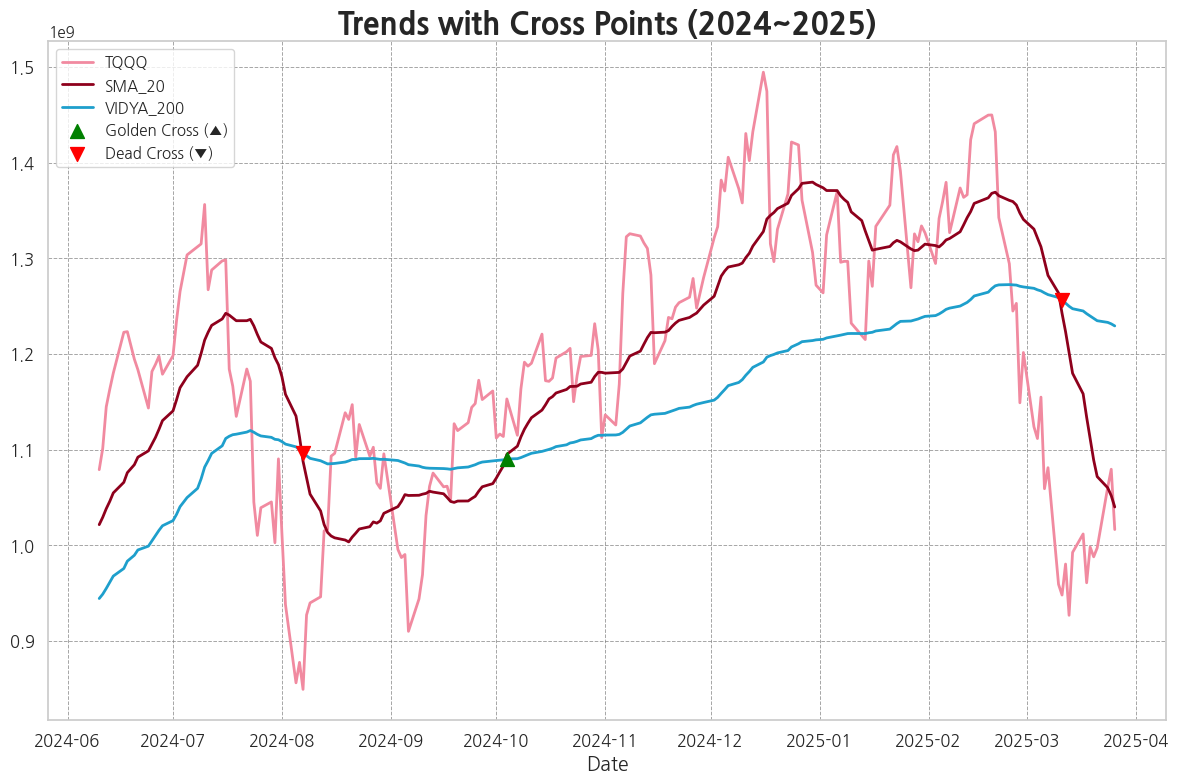

In [111]:
trend_cross_plot(signal_df.tail(200), yscale='linear')

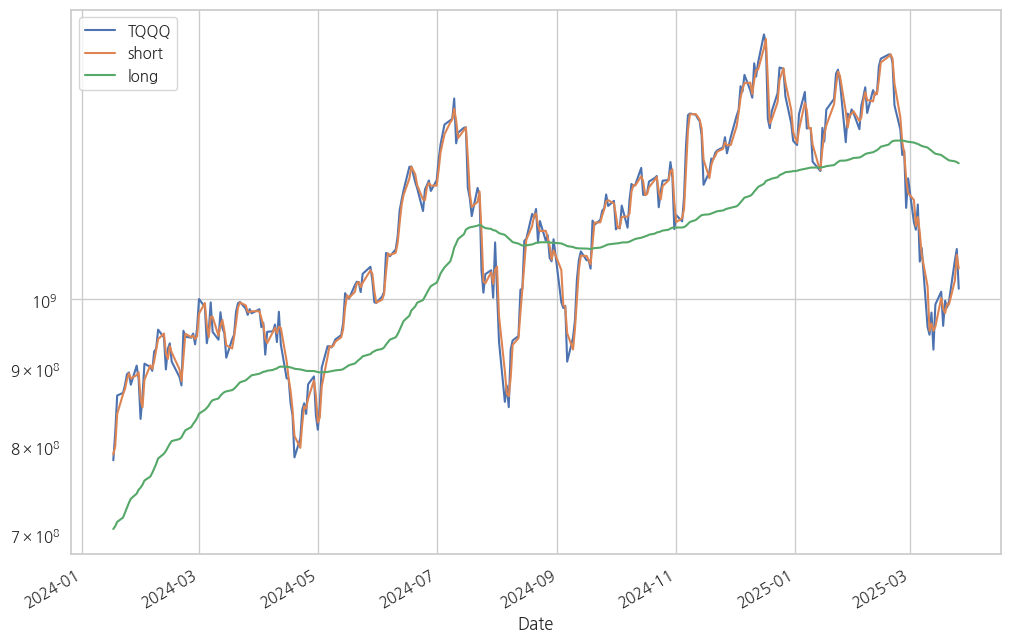

In [27]:
signal_df.tail(300).plot()
plt.yscale('log')
plt.show()

In [12]:
anal_funcs.get_Vol_report(tqqq_res, method='a', unit='daily', rf=0)

,Return,Volatility,Volatility(Down),Residual,Beta,Sharpe_Ratio,Sortino_Ratio,Trainer_Ratio,Jensen_Alpha,Info_Ratio
Ticker,,,,,,,,,,
TQQQ,36.02,18.85,11.76,0.00,1.00,1.91,3.06,36.02,0.00,NaN
SGOV,4.43,0.30,0.00,18.86,-0.52,14.76,6320.74,-8.50,23.18,-1.68
Strategy,38.83,12.50,6.12,13.77,1.03,3.11,6.35,37.68,1.71,0.20


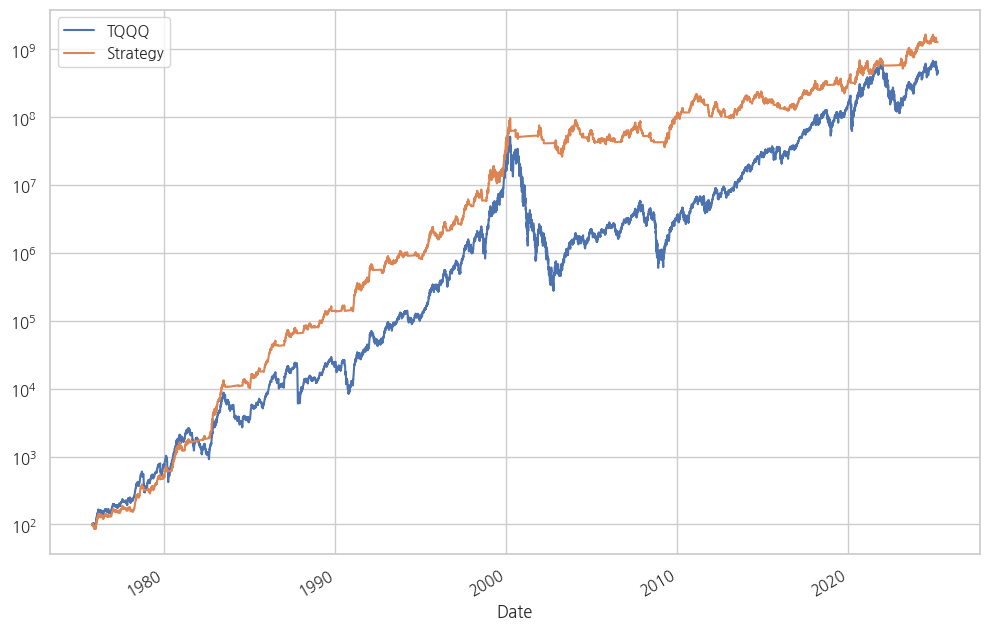

In [13]:
tqqq_res[['TQQQ', 'Strategy']].plot()
plt.yscale('log')
plt.show()

In [ ]:
ticker = 'QLD'

df_ori = yf.download(ticker, ignore_tz = True, auto_adjust=True)
df_ori.columns = [x[0] for x in df_ori.columns]
## df_ori = df_ori.reset_index()

In [188]:
def calculate_cmo(price_series, period=14):
    """Chande Momentum Oscillator (CMO) 계산"""
    delta = price_series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta <= 0, -delta, 0)

    sum_gain = pd.Series(gain, index=price_series.index).rolling(window=period).sum()
    sum_loss = pd.Series(loss, index=price_series.index).rolling(window=period).sum()

    cmo = 100 * (sum_gain - sum_loss) / (sum_gain + sum_loss)
    cmo = cmo.fillna(0)
    return cmo

def calculate_vidya(price_series, volume_series=None, period=14, alpha_factor=0.2, volumetric=True):
    """
    VVIDYA (Volumatic Variable Index Dynamic Average) 계산
    - price_series: 종가 데이터 (Series)
    - volume_series: 거래량 데이터 (Series)
    - period: CMO 및 이동 평균 계산 기간
    - alpha_factor: 가중치 스케일링 계수 (기본 0.2)
    """
    # CMO 계산
    cmo = calculate_cmo(price_series, period)/100
    
    # 가변 Alpha 계산
    if volumetric and (volume_series is not None):
        normalized_volume = volume_series / volume_series.rolling(period).mean()
        normalized_volume = normalized_volume.fillna(1)  # 첫 부분 NaN 방지
        alpha = alpha_factor * np.abs(cmo) * normalized_volume
    else:
        alpha = alpha_factor * np.abs(cmo)
        
    alpha = alpha.clip(lower=0.01, upper=0.99)  # 너무 작은 값 방지

    # VVIDYA 초기화
    vidya = np.zeros_like(price_series)
    vidya[period] = price_series.iloc[period]  # 첫 번째 값 초기화

    # 적응형 EMA 계산
    for i in range(period + 1, len(price_series)):
        vidya[i] = vidya[i - 1] + alpha.iloc[i] * (price_series.iloc[i] - vidya[i - 1])

    # 결과를 Series로 반환
    return pd.Series(vidya, index=price_series.index)

In [189]:
vidya = calculate_vidya(df_ori['Close'], df_ori['Volume'], period=200, alpha_factor=0.2, volumetric = False)
vvidya = calculate_vidya(df_ori['Close'], df_ori['Volume'], period=200, alpha_factor=0.2, volumetric = True)

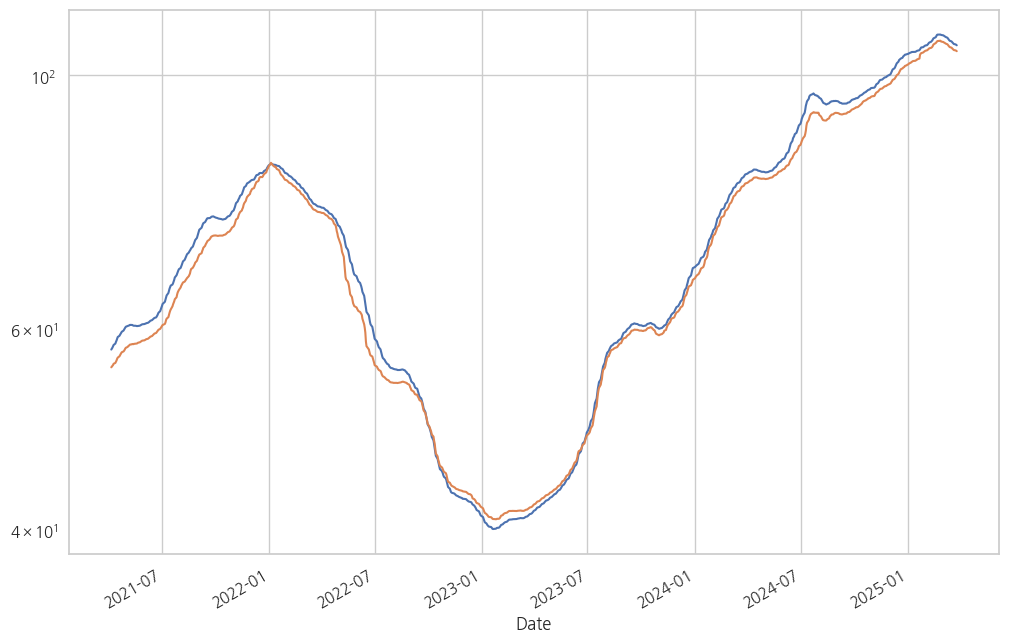

In [191]:
# df_ori['Close'].tail(1000).plot()
# df_ori['Close'].rolling(200).mean().tail(1000).plot()
vidya.tail(1000).plot()
vvidya.tail(1000).plot()
plt.yscale('log')

In [26]:
def chande_momentum_oscillator(close, period=14):
    """Chande Momentum Oscillator (CMO) 계산"""
    diff = close.diff(1)
    up = np.where(diff > 0, diff, 0)
    down = np.where(diff < 0, -diff, 0)
    sum_up = pd.Series(up).rolling(window=period).sum()
    sum_down = pd.Series(down).rolling(window=period).sum()
    cmo = 100 * (sum_up - sum_down) / (sum_up + sum_down)
    return cmo

def calc_vidya(close, volume, cmo, period=14, volumetric=False):
    close = close[period:]  # CMO 계산 (첫 14일은 NaN)
    cmo = cmo[period:]  # CMO 계산 (첫 14일은 NaN)
    """평활 계수를 반영한 VIDYA 계산"""
    vidya_values = [close.iloc[0]]  # 첫 번째 값 초기화
    alpha = 2 / (period + 1)  # 평활 계수
    
    if volumetric == True:
        avg_volume = volume.rolling(window=period).mean()[period:]
        nomalized_volume = volume / avg_volume

    for i in range(1, len(close)):
        if volumetric == True:
            dynamic_alpha = nomalized_volume.iloc[i] * alpha * abs(cmo.iloc[i] / 100)  # CMO를 이용한 동적 평활 계수
        else:
            dynamic_alpha = alpha * abs(cmo.iloc[i] / 100)
        current_vidya = vidya_values[-1] + dynamic_alpha * (close.iloc[i] - vidya_values[-1])
        vidya_values.append(current_vidya)
        
    return pd.Series(vidya_values, index=close.index)

In [27]:
cmo = chande_momentum_oscillator(df_ori['Close'])
vidya = calc_vidya(df_ori['Close'], df_ori['Volume'], cmo, volumetric=True)

In [28]:
vidya

Date
2006-07-12    1.788005
2006-07-13         NaN
2006-07-14         NaN
2006-07-17         NaN
2006-07-18         NaN
                ...   
2025-03-19         NaN
2025-03-20         NaN
2025-03-21         NaN
2025-03-24         NaN
2025-03-25         NaN
Length: 4706, dtype: float64

<Axes: xlabel='Date'>

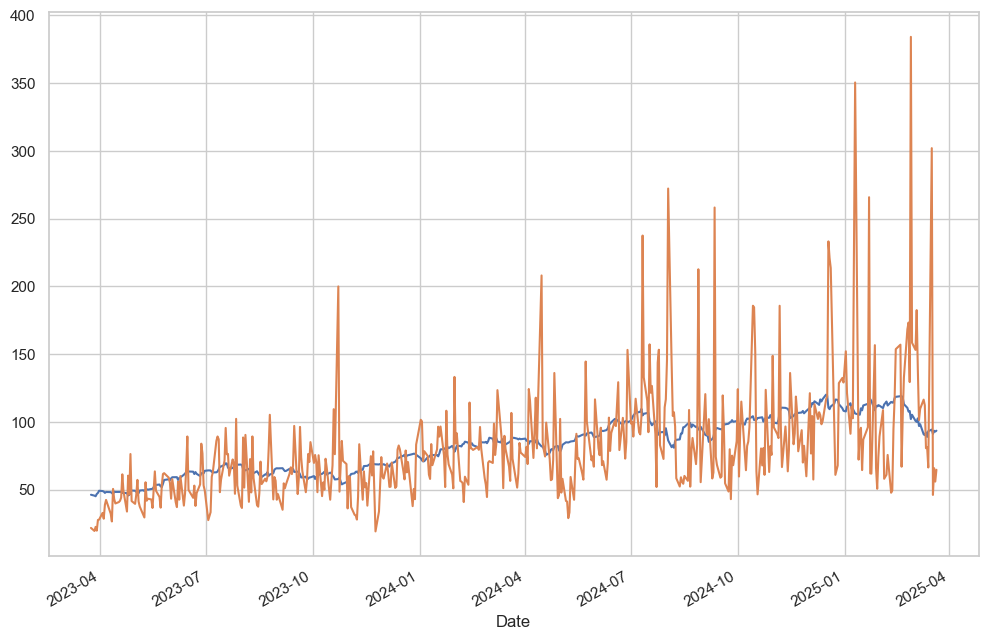

In [36]:
df_ori['Close'].tail(500).plot()
## vidya.tail(500).plot()
vvidya.tail(500).plot()

<Axes: xlabel='Date'>

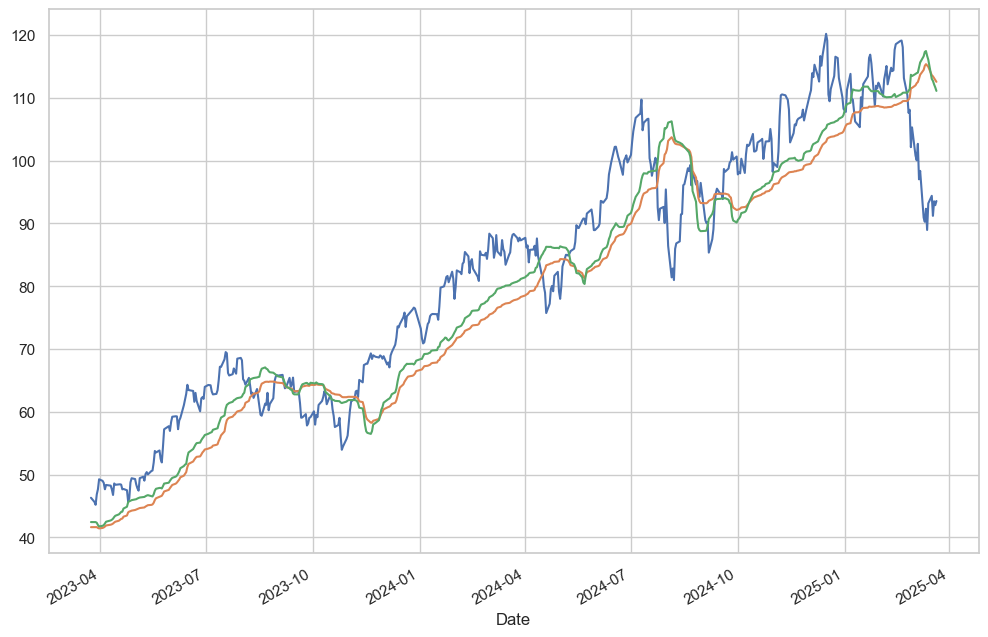

In [18]:
df_ori['Close'].tail(500).plot()
vvidya_values_up.tail(500).plot()
vvidya_values_down.tail(500).plot()

In [169]:
VVIDYA

array([  1.78800452,   1.81434673,   1.82495074, ..., 113.60747562,
       113.42388638, 113.12769195])

In [161]:
VVIDYA

array([  1.78800452,   1.81434673,   1.82495074, ..., 113.60747562,
       113.42388638, 113.12769195])

In [118]:
VVIDYA

array([1.97106135,        nan,        nan, ..., 0.        , 0.        ,
       0.        ])

In [120]:
alpha

Date
2006-07-12   NaN
2006-07-13   NaN
2006-07-14   NaN
2006-07-17   NaN
2006-07-18   NaN
              ..
2025-03-13   NaN
2025-03-14   NaN
2025-03-17   NaN
2025-03-18   NaN
2025-03-19   NaN
Length: 4702, dtype: float64

In [95]:

normalized_volume = volume_series / volume_series.rolling(period).mean()
normalized_volume = normalized_volume[period:]  # CMO 계산 (첫 14일은 NaN)

# CMO와 거래량을 반영한 가변 알파(alpha) 계산
alpha = alpha_factor * np.abs(CMO) * normalized_volume
alpha = alpha.clip(lower=0.01, upper=0.99)  # 너무 작은 값 방지

# VVIDYA 초기화
VVIDYA = np.zeros_like(price_series)
VVIDYA[0] = price_series.iloc[0]  # 첫 값 초기화

# 적응형 EMA 적용
for i in range(1, len(price_series)):
    VVIDYA[i] = VVIDYA[i - 1] + alpha.iloc[i] * (price_series.iloc[i] - VVIDYA[i - 1])

IndexError: single positional indexer is out-of-bounds

In [91]:
CMO

14     -0.318161
15     -0.330541
16     -0.362871
17     -0.360460
18     -0.253939
          ...   
4711   -0.555454
4712   -0.382157
4713   -0.304188
4714   -0.366118
4715   -0.202728
Length: 4702, dtype: float64

In [60]:
# VVIDYA 초기화
VVIDYA = np.zeros_like(price_series)
VVIDYA[0] = price_series.iloc[0]  # 첫 값 초기화

In [64]:
normalized_volume

Date
2006-06-21         NaN
2006-06-22         NaN
2006-06-23         NaN
2006-06-26         NaN
2006-06-27         NaN
                ...   
2025-03-13    0.792019
2025-03-14    0.649417
2025-03-17    2.962878
2025-03-18    0.455243
2025-03-19    0.647402
Name: Volume, Length: 4716, dtype: float64

In [62]:
alpha.iloc[i]

nan

In [56]:
VVIDYA[i - 1] + alpha.iloc[i] * (price_series.iloc[i] - VVIDYA[i - 1])

array([1.97106135,        nan,        nan, ...,        nan,        nan,
              nan])